<a href="https://colab.research.google.com/github/yyyyyokoko/590FaceMaskDetection/blob/master/model_MobileNetV2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os, random
import pathlib
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import cv2

from tensorflow.keras.models import load_model



In [ ]:
!ls "/content/drive/My Drive/ColabNotebooks/Face Mask Dataset/sample_training"

mask  nomask


In [3]:
data_train = '/content/drive/My Drive/ColabNotebooks/Face Mask Dataset/Validation/'
data_train

'/content/drive/My Drive/ColabNotebooks/Face Mask Dataset/Validation/'

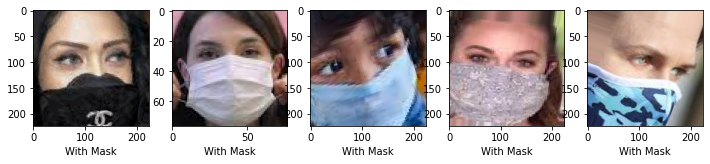

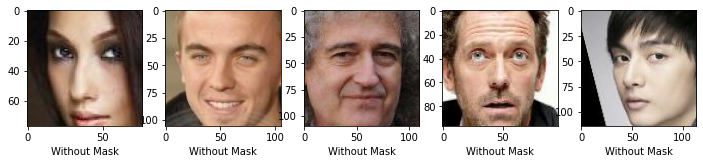

In [ ]:
#with Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(data_train+"mask/"))
    plt.subplot(1,5,i+1)
    img = load_img(data_train+"mask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(data_train+"nomask/"))
    plt.subplot(1,5,i+1)
    img = load_img(data_train+"nomask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

In [12]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.2)

train = train_datagen.flow_from_directory(directory=data_train,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32,subset = "training")


valid = train_datagen.flow_from_directory(directory=data_train,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32,subset="validation")

Found 526 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [13]:
valid.class_indices

{'mask': 1, 'nomask': 0}

In [14]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(160, 160, 3)))

for layer in baseModel.layers:
    layer.trainable = False

model = Sequential()
model.add(baseModel)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))


In [15]:

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 64002     
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics ="accuracy")


In [17]:
checkpoint = ModelCheckpoint("moblenet_facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [18]:
# history = model.fit_generator(generator=train,steps_per_epoch=len(train)// 32,
#                               validation_data=valid,
#                              validation_steps = len(valid)//32,
#                               callbacks=[checkpoint,earlystop],
#                               epochs=15)


history = model.fit_generator(train,
                              epochs=10,
                              validation_data=valid,
                              callbacks=[checkpoint])


Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9468
Epoch 00001: val_accuracy improved from -inf to 0.98462, saving model to moblenet_facemask.h5
17/17 [==============================] - 157s 9s/step - loss: 0.2408 - accuracy: 0.9468 - val_loss: 0.0772 - val_accuracy: 0.9846
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9867
Epoch 00002: val_accuracy did not improve from 0.98462
17/17 [==============================] - 5s 290ms/step - loss: 0.0891 - accuracy: 0.9867 - val_loss: 0.0694 - val_accuracy: 0.9846
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9924
Epoch 00003: val_accuracy improved from 0.98462 to 0.99231, saving model to moblenet_facemask.h5
17/17 [==============================] - 5s 302ms/step - loss: 0.0359 - accuracy: 0.9924 - val_loss: 0.0265 - val_accuracy: 0.9923
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.0462 - acc

### Evaluation 

In [27]:
import pandas as pd

training_accuary = pd.DataFrame.from_dict(history.history) #.drop(columns = ['val_loss', 'val_accuracy'])


In [20]:
model.save("/content/drive/My Drive/ColabNotebooks/face_mask_mobileNet.h5")


In [21]:
model = load_model('/content/drive/My Drive/ColabNotebooks/face_mask_new.h5')

In [22]:
test_data = "/content/drive/My Drive/ColabNotebooks/Face Mask Dataset/sample_training"
test = train_datagen.flow_from_directory(directory=test_data,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32)

Found 96 images belonging to 2 classes.


In [23]:
model.evaluate(valid)

5/5 [==============================] - 1s 152ms/step - loss: 0.3520 - accuracy: 0.9923


[0.35198649764060974, 0.9923076629638672]

In [24]:
model.evaluate(train)

17/17 [==============================] - 4s 231ms/step - loss: 0.3573 - accuracy: 0.9943


[0.35727551579475403, 0.9942965507507324]

In [25]:
model.evaluate(test)

3/3 [==============================] - 17s 6s/step - loss: 0.4110 - accuracy: 0.9896


[0.41095778346061707, 0.9895833134651184]

In [28]:
training_accuary


,loss,accuracy,val_loss,val_accuracy
0,0.240838,0.946768,0.077205,0.984615
1,0.089050,0.986692,0.069421,0.984615
2,0.035928,0.992395,0.026543,0.992308
3,0.046189,0.992395,0.011461,0.992308
4,0.014908,0.996198,0.113011,0.976923
5,0.043286,0.996198,0.086169,0.984615
6,0.002189,1.000000,0.119404,0.976923
7,0.030388,0.992395,0.039902,0.992308
8,0.014855,0.996198,0.002323,1.000000
9,0.017128,0.998099,0.159120,0.984615


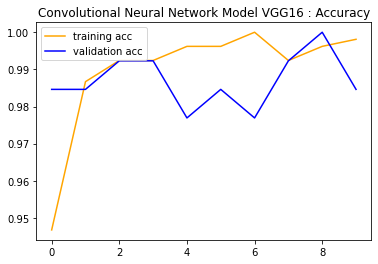

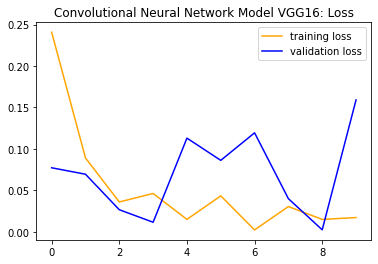

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Convolutional Neural Network Model VGG16 : Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training loss')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation loss')
plt.title('Convolutional Neural Network Model VGG16: Loss')
plt.legend()
plt.show()

In [ ]:

pred = model.predict_classes(test)
pred[:15]


array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [ ]:
pred = model.predict(test)
pred[:15]

array([[1.0000000e+00, 1.0000000e+00],
       [4.0012004e-08, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [4.8231014e-16, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [1.4321167e-23, 1.0000000e+00],
       [5.7534179e-11, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [3.4715612e-03, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [1.1031893e-08, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00]], dtype=float32)